# Creating Word Vectors

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import functions as f

C:\Users\klaud\Anaconda3\envs\fastai-nlp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Text preprocessing

The goal of this part is to transform product reviews into lists of tokens. Since the dataset consists of over 1.4M reviews, for the purpose of this project it will be limited to 100k (to fasten computations).

Text preprocessing includes:
- converting text to lowercase
- removing punctuation
- tokenization
- removing stop words
- lemmatization

In [13]:
df = pd.read_csv('data/reviews_toys_games.csv')
df.sample(5)

,review,sentiment
1171865,Very nice toy!,1
230362,"We gave this to our then, 14 month old dd and ...",1
120094,The stuffed horse I recieved looks nothing lik...,0
893200,My grandson loves the Star Wars lego sets.,1
1160189,I like this line of Teenys. Hadn't seen this o...,1


In [6]:
print('Share of positive reviews in the whole dataset:', sum(df['sentiment'])/len(df))

Share of positive reviews in the whole dataset: 0.914674872933972


In [7]:
df_sample = df.sample(100000, random_state=11).reset_index(drop=True)
print('Share of positive reviews in the sample:', sum(df_sample['sentiment'])/len(df_sample))

Share of positive reviews in the sample: 0.9148


In [8]:
reviews = df_sample['review'].to_list()
sentiment = df_sample['sentiment'].to_list()

In [9]:
reviews_tokens = f.normalize_text(reviews)

In [11]:
f.save_pickle(reviews_tokens, 'data/reviews_tokens_100k.pickle')
f.save_pickle(sentiment, 'data/sentiment_100k.pickle')

df_sample.to_csv('data/reviews_toys_games_100k.csv', index=False)

In [12]:
del df, df_sample, reviews, reviews_tokens, sentiment, corpus_counter, n_tokens

## Creating word vectors

There are several approaches aimed on transforming text into word vectors. In this script reviews will be presented as:
- bag of words vectors
- TFIDF word vectors
- SVD and NMF embeddings
- Word2Vec embeddings

In [2]:
reviews_tokens = f.load_pickle('data/reviews_tokens_100k.pickle')

In [3]:
corpus_counter, n_tokens = f.distinct_corpus_words(reviews_tokens)
word2ind, ind2word = f.build_dictionary(corpus_counter)
reviews_ind = [f.text_token2ind(review, word2ind) for review in reviews_tokens]

In [4]:
print('Words in the dictionary: ', n_tokens)
print('Most common words:\n', corpus_counter[:10])

Words in the dictionary:  45629
Most common words:
 [('love', 42733), ('great', 26982), ('play', 20313), ('toy', 16773), ('old', 16037), ('like', 15440), ('buy', 14097), ('kid', 13786), ('game', 13429), ('fun', 13182)]


In [19]:
f.save_pickle(reviews_ind, 'data/reviews_ind_100k.pickle')

### Bag of Words

The bag of words model is the simplest representation of text used in NLP. It enables extracting features from text to use in machine learning algorithms. It consists of a vocabulary of known words and a count of the occurrence of words withing the document.

In the bag of words model, each document is represented as a word-count vector and the size of this vector is equal to the number of elements in your vocabulary. Since the documents contain only limited number of words, vectors mostly consist of zeros, thus the matrix can be considered as sparse. To avoid memory errors, the output of this BOW implementation is a matrix represented in scipy sparse format.

In [30]:
M_bow = f.build_bow(reviews_ind, n_tokens, 6000)
M_bow.shape

(100000, 6000)

In [31]:
ind_test = 111
print('text of test review: ', reviews_tokens[ind_test])
print('occurrences of words:',
      '\nfigure:', M_bow[ind_test, word2ind['figure']],
      '\nlove:', M_bow[ind_test, word2ind['love']])

text of test review:  ['great', 'figure', 'right', 'price', 'love', 'amaze', 'figure', 'see']
occurrences of words: 
figure: 2 
love: 1


In [50]:
f.save_pickle(M_bow, 'data/M_bow_100k.pickle')
del M_bow

#### Convert string to BOW vector

In [35]:
review_test = 'This game is amazing ^^, my son plays with it all the time!'

In [36]:
review_tokens_test = f.normalize_single_text(review_test)
print(review_tokens_test)

review_ind_test = f.text_token2ind(review_tokens_test, word2ind)
print(review_ind_test)

['game', 'amaze', 'son', 'play', 'time']
[8, 171, 20, 2, 18]


In [37]:
f.build_single_bow(review_ind_test, n_tokens, 6000)

array([0., 0., 1., ..., 0., 0., 0.])

## TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF is aa statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. It is a weight often used in information retrieval and text mining.

In order to optimize calculations, scikit-learn implementation was used.

In [32]:
vectorizer = TfidfVectorizer(max_features=6000)
M_tfidf = vectorizer.fit_transform([' '.join(r) for r in reviews_tokens])
M_tfidf.shape

(100000, 6000)

In [33]:
ind_test = 111
print('text of test review: ', reviews_tokens[ind_test])
print('TFIDF of words:',
      '\nfigure:', M_tfidf[ind_test, vectorizer.vocabulary_['figure']],
      '\nlove:', M_tfidf[ind_test, vectorizer.vocabulary_['love']])

text of test review:  ['great', 'figure', 'right', 'price', 'love', 'amaze', 'figure', 'see']
TFIDF of words: 
figure: 0.6571834159729407 
love: 0.15079671030826042


In [80]:
f.save_pickle(M_tfidf, 'data/M_tfidf_100k.pickle')
f.save_pickle(vectorizer, 'data/tfidf_vectorizer_100k.pickle')

del M_tfidf

#### Convert test string into TFIDF vector

In [38]:
vectorizer.transform([' '.join(review_tokens_test)]).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

## SVD & NMF

In [5]:
M_co_occurrence = f.build_co_occurrence_matrix(reviews_ind, n_tokens, window_size=4)
svd_reduced_co_occurrence = f.matrix_reduce(M_co_occurrence, method='svd', n_dim=5)

In [6]:
M_svd = np.stack([f.avg_svd_embeddings(ind, svd_reduced_co_occurrence, word2ind) for ind in reviews_ind])
M_svd.shape

(100000, 5)

In [7]:
print(M_svd)

[[1911.32207339  -42.3008621  -106.35712762  210.05471684 -132.18560823]
 [3295.92654462  -56.23929451 -170.39622825  528.90670812 -241.31622706]
 [6867.38013304  903.19521856 -400.92224674  805.06355755 -199.51484942]
 ...
 [3972.9144837    30.86035388 -292.65034272  950.86000508 -256.23313572]
 [1786.67156989 -840.48356118    8.95530309  -40.0365764  -613.58495126]
 [1798.51858078 -323.86781434   12.39257531 -192.91452964  260.19561892]]


In [13]:
viz_words = ['son', 'daughter', 'good', 'bad', 'great', 'game', 'toy', 'play']

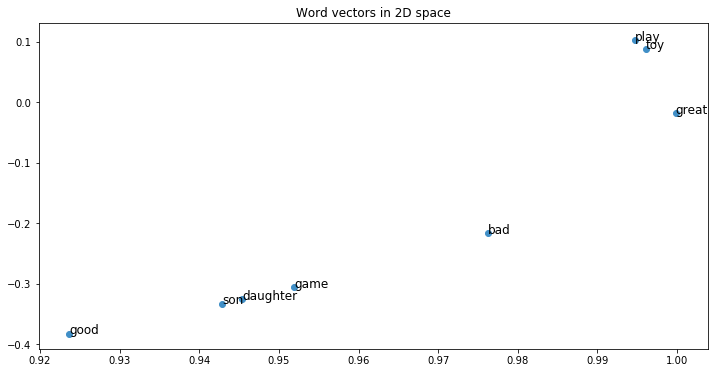

In [14]:
M_svd_2d = f.matrix_reduce(M_svd, method='svd', n_dim=2)
f.plot_vectors_2d(M_svd_2d, viz_words, word2ind)

In [63]:
f.save_pickle(M_svd, 'data/M_svd_100k.pickle')
del M_svd

In [15]:
nmf_reduced_co_occurrence = f.matrix_reduce(M_co_occurrence, method='nmf', n_dim=5)
M_nmf = np.stack([f.avg_svd_embeddings(ind, nmf_reduced_co_occurrence, word2ind) for ind in reviews_ind])
M_nmf.shape

(100000, 5)

In [16]:
print(M_nmf)

[[ 7.3097858   4.99694461  4.12937381  3.85311444  4.42572246]
 [13.11342565  9.02945661  8.11215029  4.90424298  7.3868852 ]
 [19.13474032 22.07550104 19.34264332 17.87122237 14.25161494]
 ...
 [16.22325284 12.95650189 11.7224122   1.51092228  9.67157149]
 [13.12041851  0.43404616  0.1614864   3.36021049  1.80107849]
 [ 4.20430857  1.72494657  1.06437739  7.91029615  8.99245002]]


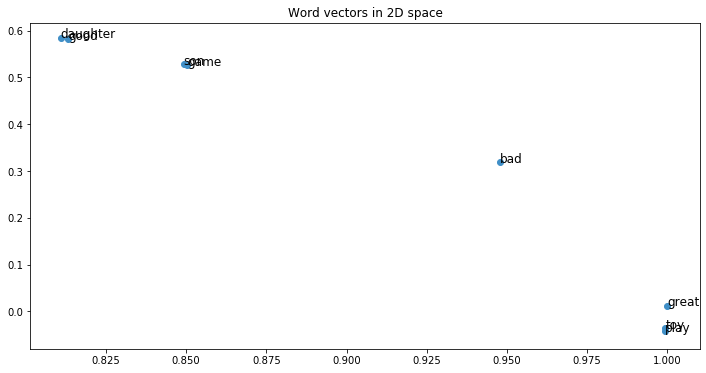

In [19]:
M_nmf_2d = f.matrix_reduce(M_nmf, method='svd', n_dim=2)
f.plot_vectors_2d(M_nmf_2d, viz_words, word2ind)

In [67]:
f.save_pickle(M_nmf, 'data/M_nmf_100k.pickle')
del M_nmf

#### Convert test string into SVD vector

In [45]:
f.avg_svd_embeddings(review_ind_test, svd_reduced_co_occurrence, word2ind)

array([4686.7329675 , -783.00008166,   60.1869311 , -652.26470709,
       1337.28247194])

In [46]:
f.avg_svd_embeddings(review_ind_test, nmf_reduced_co_occurrence, word2ind)

array([ 8.1192513 ,  7.95502596,  8.2426332 ,  4.97297233, 30.26983157])

## Word2Vec

In [23]:
w2v_model = Word2Vec(min_count=5,
                     window=3,
                     size=100,
                     workers=3)

In [24]:
w2v_model.build_vocab(reviews_tokens)
w2v_model.train(reviews_tokens, total_examples=w2v_model.corpus_count, epochs=30)

(42810196, 50905110)

In [25]:
M_word2vec = np.stack([f.avg_w2v_embeddings(review, w2v_model) for review in reviews_tokens])
M_word2vec.shape

(100000, 100)

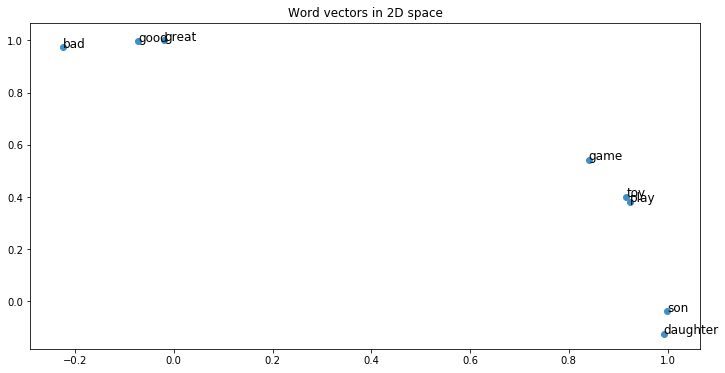

In [26]:
M_w2v_words = w2v_model.wv[viz_words]
M_w2v_words_2d = f.matrix_reduce(M_w2v_words, 'svd', n_dim=2)
w2v_word2ind = {e:i for i, e in enumerate(viz_words)}
f.plot_vectors_2d(M_w2v_words_2d, viz_words, w2v_word2ind)

In [ ]:
f.save_pickle(M_word2vec, 'data/M_word2vec_100k.pickle')
del M_word2vec

#### Convert test string into Word2Vec vector


In [50]:
f.avg_w2v_embeddings(review_tokens_test, w2v_model)

array([-0.6744937 , -1.213199  , -1.0238752 ,  0.03260673,  0.14862743,
       -0.57608354, -0.97421134,  0.1169243 ,  0.48017493,  0.19547293,
       -0.08849601,  0.4695232 , -0.8236923 , -0.02472959, -0.3976046 ,
        1.0270191 ,  0.4643627 , -0.8565401 , -0.7912302 , -0.720211  ,
       -0.58584607,  0.17372887,  0.4971673 , -0.4052841 , -1.0920483 ,
        1.1958758 , -0.03497669, -0.14230634,  0.26223752,  1.1432084 ,
       -0.42724353, -0.6125147 ,  0.7073124 , -0.2035555 , -0.06413691,
       -0.07212701,  1.421565  ,  0.2852187 ,  0.12921596,  0.38929284,
        0.27826518, -0.15381488,  0.51603484,  0.1501861 ,  0.0022732 ,
       -1.0745842 ,  0.43908343, -0.5177313 , -0.066209  , -0.3127257 ,
        0.34621722,  0.5059077 , -0.0310218 , -0.99942416, -0.68248177,
       -0.47090307,  0.11102493, -0.21090198, -0.763354  ,  0.2564712 ,
        0.44010442,  0.25490254,  0.1106451 , -0.4833456 , -0.08942149,
        0.2028394 , -0.4401844 ,  0.10165071,  0.88994044,  0.98